To do:
see https://www.notion.so/aiea/Tasks-8245554f700248038fe006a4c0475ab9?p=125ac685e25d4612b0999d1a32b29de2&pm=s 

In [1]:
import chess
import random
from math import inf
from collections import Counter
from IPython.display import display, clear_output
MAX_DEPTH = 3

The board evaluation is built up of several different scoring functions whose combined sum gives the final board score. Every scoring function will have its normalized return value multiplied by a weight.

In [2]:
SCORES = {
    chess.KING : 200,
    chess.QUEEN : 9,
    chess.ROOK : 5,
    chess.BISHOP : 3,
    chess.KNIGHT : 3,
    chess.PAWN : 1,
}
# Scoring function based on the combined weighted score of multiple smaller scoring functions
def evaluation(b: chess.Board, player: bool) -> dict:
    if b.is_checkmate():
        scores_dict = {}
        if b.turn == chess.WHITE:
            scores_dict['total_score'] = -inf
        else:
            scores_dict['total_score'] = inf
        return scores_dict

    # 15 total scores
    material_score = eval_material(b, player)
    reinforced_pieces_score = eval_reinforced_pieces(b, player)
    knight_mobility_score = eval_mobility(b, player, 2)
    bishop_mobility_score = eval_mobility(b, player, 3)
    rook_mobility_score = eval_mobility(b, player, 4)
    queen_mobility_score = eval_mobility(b, player, 5)
    # king_attacked_score = eval_king_attacked(b, player)
    # king_defended_score = eval_king_defended(b, player)
    # bishop_pair_score = eval_bishop_pair(b, player)
    # center_pawn_count_score = eval_center_pawn_count(b, player)
    # weak_count_score = eval_weak_count(b, player)
    # enemy_knight_on_weak_score = eval_enemy_knight_on_weak(b, player)
    # king_castled_score = eval_king_castled(b, player)
    # rook_on_seventh_score = eval_rook_on_seventh(b, player)
    # ranked_passed_pawn_score = eval_ranked_passed_pawn(b, player)

    scores_dict = {
        'material_score' : material_score,
        'reinforced_pieces_score' : reinforced_pieces_score,
        'knight_mobility_score' : knight_mobility_score,
        'bishop_mobility_score' : bishop_mobility_score, 
        'rook_mobility_score' : rook_mobility_score, 
        'queen_mobility_score' : queen_mobility_score, 
        # 'king_attacked_score' : king_attacked_score,
        # 'king_defended_score' : king_defended_score,
        # 'bishop_pair_score' : bishop_pair_score,
        # 'center_pawn_count_score' : center_pawn_count_score, 
        # 'weak_count_score' : weak_count_score, 
        # 'enemy_knight_on_weak_score' : enemy_knight_on_weak_score, 
        # 'king_castled_score' : king_castled_score, 
        # 'rook_on_seventh_score' : rook_on_seventh_score, 
        # 'ranked_passed_pawn_score' : ranked_passed_pawn_score,
    }

    total_score = 0
    for key in scores_dict:
        total_score += scores_dict[key]
    scores_dict['total_score'] = total_score

    return scores_dict

# Very basic eval function based on counting pieces on the board
def eval_material(b: chess.Board, player: bool) -> int:   
    # The list needs to be size 7 because PIECE_TYPES goes from 1 to 6
    # Creates a dictionary of all the pieces on the board, and counts them
    piece_count = { c : [0] * 7 for c in chess.COLORS }
    for piece in b.piece_map().values():
        piece_count[piece.color][piece.piece_type] += 1

    # Sums the difference in count of each piece type, multiplied by that type's material value
    total = 0
    for piece in chess.PIECE_TYPES:
        diff = piece_count[chess.WHITE][piece] - piece_count[chess.BLACK][piece]
        total += SCORES[piece] * diff
    
    return total if player else -total

def eval_reinforced_pieces(b: chess.Board, player: bool) -> int:
    # Iterates through every position that a piece of colour 'player' is on
    # If the position can be attacked by the pieces of 'player', then consider that a reinforced piece
    # Return the number of reinforced pieces  belonging to 'player'
    position_piece_dict = b.piece_map()
    reinforced_pieces = 0

    for board_position in position_piece_dict:

        if player == position_piece_dict[board_position].color:
            if b.is_attacked_by(player, board_position):
                reinforced_pieces += 1
    
    return reinforced_pieces/16

def eval_king_attacked(b: chess.Board, player: bool) -> int:
    # Get 'adj_king_set', all the positions of the tiles adjacent to the king belonging to 'player'
    # Use board.attacks() to get the pieces belonging to 'not player' that attack each position in 'king_set'
    # Get the subset of those positions that are attacked by 'not player'
    
    # get all tiles adjacent to the king
    king_position = b.king(player)
    adj_king_set = b.attacks(king_position)
    pieces_attacking_square = set()
    for square in adj_king_set:
        pieces_attacking_square.update(b.attackers(not player, square))
    
    # Get the material value of all the attackers
    mat_val_of_attackers = 0
    for square in pieces_attacking_square:
        piece = b.piece_at(square).piece_type
        mat_val_of_attackers += SCORES[piece]

    return mat_val_of_attackers/30

def eval_king_defended(b: chess.Board, player: bool):
    ##is the material value of the pieces of the Player A that are acting on Player A’s king’s adjacent squares

    count = 0

    king_square = b.king(player)

    adjacent_squares = b.attacks(king_square)

    for square in adjacent_squares:
        for piece in b.attackers(player, square):
            if piece is not None and b.piece_type_at(piece) != chess.KING:
                count += SCORES[b.piece_type_at(piece)]
        
    return count/30

def eval_bishop_pair(b: chess.Board, player: bool):
    ##checks if there is a pair of bishops; a pair of bishops provides an advantages

    if len(b.pieces(chess.BISHOP, b.turn)) >= 2:
        return 1
    
    else:
        return 0
    
def eval_mobility(b: chess.Board, player: bool, p: int):
    ##Checks the number of spots on the board a specific type of piece can move to
    
    count = 0

    for move in b.legal_moves:
        from_square = move.from_square
        piece = b.piece_at(from_square)
        
        if piece.piece_type == p and piece.color == player:
            count += 1
    
    if p == 1:
        return count/16
    if p == 2:
        return count/16
    if p == 3:
        return count/26
    if p == 4:
        return count/28
    if p == 5:
        return count/27
    

def eval_center_pawn_count(b: chess.Board, player: bool):
    ##Counts the number of pawns in the center squares

    count = 0

    center_squares = [chess.E4, chess.E5, chess.D4, chess.D5]

    for square in center_squares:
        piece = b.piece_at(square)
        if piece is not None and piece.piece_type == chess.PAWN and piece.color == player:
            count +=1

    return count/4

def eval_weak_count(b: chess.Board, player: bool):
    # Returns the number of squares that can be attacked by the player's pawns
    attacked_squares = set()
    pawn_str = 'P' if player else 'p'
    for square in range(32) if player else range(32,64):
        if square in b.piece_map():
            piece = b.piece_map()[square]
            if piece == chess.Piece.from_symbol(pawn_str):
                # print(square)
                attacked_squares.update(b.attacks(square))
    return (16 - len(attacked_squares))/16

def eval_enemy_knight_on_weak(b: chess.Board, player: bool):
    # Returns the number of knights of Player B that are in the weak squares of Player A

    attacked_squares = set()
    pawn_str = 'p' if player else 'P'
    for square in range(32,64) if player else range(32):
        if square in b.piece_map():
            piece = b.piece_map()[square]
            if piece == chess.Piece.from_symbol(pawn_str):
                attacked_squares.update(b.attacks(square))

    count = 0
    knight_str = 'N' if player else 'n'
    for square in range(32,64) if player else range(32):
        if square in b.piece_map():
            piece = b.piece_map()[square]
            if piece == chess.Piece.from_symbol(knight_str):
                if square not in attacked_squares:
                    count += 1
    return count/2

def eval_king_castled(b: chess.Board, player: bool):
    if not b.move_stack: #no moves made yet
        return 0
    castling_moves = {
        chess.WHITE: {
            'w_kingside': chess.Move.from_uci('e1g1'),
            'w_queenside': chess.Move.from_uci('e1c1')
        },
        chess.BLACK: {
            'b_kingside': chess.Move.from_uci('e8g8'),
            'b_queenside': chess.Move.from_uci('e8c8')
        }
    }
    player_castled = 0
    if(player == True):
        kingside = castling_moves[chess.WHITE]['w_kingside']
        queenside = castling_moves[chess.WHITE]['w_queenside']
    else:
        kingside = castling_moves[chess.BLACK]['b_kingside']
        queenside = castling_moves[chess.BLACK]['b_queenside']
    
    for move in b.move_stack:
        if move == kingside or move == queenside:
            start_square = move.from_square
            if b.piece_at(start_square).piece_type == chess.KING:
                player_castled = 1
                break
    
    return player_castled

def eval_rook_on_seventh(b: chess.Board, player: bool):
    seventh_rank = 6 if player else 1
    rook_seventh_score = 0

    for square in chess.SQUARES:
        piece = b.piece_at(square)
        if piece and piece.piece_type == chess.ROOK and piece.color == (chess.WHITE if player else chess.BLACK):
            if chess.square_rank(square) == seventh_rank:
                rook_seventh_score += 1  

    return rook_seventh_score/2

def eval_ranked_passed_pawn_helper(b: chess.Board, square, color):
    file = chess.square_file(square) #column of pawn
    rank = chess.square_rank(square) #row of pawn
    direction = 1 if color == chess.WHITE else -1 #direction ie. 1 for white and -1 for black

    files_to_check = [file - 1, file, file + 1] #current file and adjacent files

    for adjacent_file in files_to_check: #iterate over current file and adjacent files
        if 0 <= adjacent_file < 8:
            for step in range(rank + direction, 8 if color == chess.WHITE else -1, direction): #iterates through the ranks in the direction of pawn movement
                piece = b.piece_at(chess.square(adjacent_file, step))
                if piece and piece.color != color and piece.piece_type == chess.PAWN:
                    return 0
    return 1

def eval_ranked_passed_pawn(b: chess.Board, player: bool):
    #assigns rank to passed pawns, giving higher ranks higher priority/value
    passed_pawn_scores = {
        2: 1.0,
        3: 2.0,
        4: 3.0,
        5: 4.0,
        6: 5.0,
        7: 7.0
    }
    #total score to accumulate all the passed pawns on the board
    total_score = 0
    for square in chess.SQUARES: #iterate over each square on the board
        piece = b.piece_at(square) #retrieve piece at current square
        if piece and piece.piece_type == chess.PAWN: #if there is a piece on the square and if it's a pawn
            color = piece.color #store color of the pawn
            rank = chess.square_rank(square) + 1 #store rank of pawn and add 1 to have 1-8 index
            if eval_ranked_passed_pawn_helper(b, square, color): #check if pawn is passed
                score = passed_pawn_scores.get(rank,0) #retrieve score of pawn's rank
                total_score += score if color == chess.WHITE else -score #add if white, subtract if black

    return total_score/22 if player else -total_score/22 #if white positive if black negative

In [13]:
import inspect
import ast

class Analysis:
    def __init__(self):
        self.function_links = {
            'minimax' : self.verify_minimax,
        }
    
    # Analysis Functions
    def verify_minimax(self, src: str):
        rules = [ast.For]
        return self.enforce_ruleset(src, rules)
    
    # Helper Functions
    def get_feedback(self, key, source):
        """
        The parameter 'key' tells us what analysis function to run
        The parameter 'source' is the submission code
        """
        if key in self.function_links:
            return self.function_links[key](source)
        return "Dynamic feedback implementation not found."

    def enforce_ruleset(self, src: str, rules: list[type]):
        """
        General function.
        .find() function takes (one of) arguments:
            -pattern: str
            -kind: type
            -regex: str
        
        we will update this to use regex in a bit; should be better i think
        """

        def check_local_context(local_context_node, rules):
            rule_counter = 0
            for node in ast.walk(local_context_node):
                # if node matches structural requirement, then increment rule counter
                if isinstance(node, rules[rule_counter]):
                    print(f"matching rule {rules[rule_counter]} on node {node}")
                    rule_counter += 1
                    if rule_counter >= len(rules):
                        return "Structure fully matched!"
                # if not, do nothing

            return (f"Failed to match structure on rule {rules[rule_counter]}")

# board = chess.Board()
board = chess.Board("5R2/8/8/8/8/8/4K3/8")
player = True
print(board)
        root = ast.parse(src)
    
        # here are all the contexts at the highest level inside the source code
        top_level_context_nodes = root.body[0].body
        print(top_level_context_nodes)

        # try to find the correct local context to match the first rule in the ruleset
        top_context_rule = rules[0]
        for top_node in top_level_context_nodes:
            print(top_node)
            
            if isinstance(top_node, top_context_rule):
                print(f"entering local context for rule at node {top_node}")
                return check_local_context(top_node, rules[1:])
            
        return (f"Failed to match {rules[0]}")

explainer = Analysis()

. . . . . R . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
. . . . . . . .
0.5


In [4]:
def minimax(b: chess.Board, player: bool, depth: int):

    def get_max_move(b: chess.Board, player: bool, depth: int, alpha: int, beta: int):
        # e = evaluation(b, player)['total_score']
        e = eval_material(b, player)
        if depth == 0 or abs(e) == inf:
            return e, None

        best_value = -inf
        best_moves = []
        for m in b.legal_moves:
            temp_board = b.copy()
            temp_board.push(m)
            new_value = get_min_move(temp_board, depth - 1, player, alpha, beta)[0]

            # Maintain a running max of the best move
            if new_value > best_value:
                best_value = new_value
                best_moves = [m]
            elif new_value == best_value:
                best_moves.append(m)

            # Alpha-beta pruning
            if best_value >= beta:
                break
            alpha = max(alpha, best_value)

        return best_value, random.choice(best_moves)

    def get_min_move(b: chess.Board, player: bool, depth: int, alpha: int, beta: int):
        # e = evaluation(b, player)['total_score']
        e = eval_material(b, player)
        if depth == 0 or abs(e) == inf:
            return e, None
        
        worst_value = +inf
        for m in b.legal_moves:
            temp_board = b.copy()
            temp_board.push(m)
            new_value = get_max_move(temp_board, depth - 1, player, alpha, beta)[0]

            # Maintain a running minimum
            if new_value < worst_value:
                worst_value = new_value

            # Alpha-beta pruning        
            if worst_value <= alpha:
                break
            beta = min(beta, worst_value)

        return worst_value, None

    # print("starting minimax")
    return get_max_move(b, player, depth, -inf, +inf)

'''def get_max_move(b: chess.Board, player: bool, depth: int, alpha: int, beta: int):
    # print(f"get max move depth = {depth}")
    e = evaluation(b, player)
    if depth == 0 or abs(e['total_score']) == inf:
        return e, None

    best_value = {'total_score': -inf}
    best_moves = []
    for m in b.legal_moves:
        temp_board = b.copy()
        temp_board.push(m)
        new_value = get_min_move(temp_board, player, depth - 1, alpha, beta)[0]
        
        try:
            a = new_value['total_score']
        except:
            print(f"new_value = {new_value}")

        # Maintain a running max of the best move
        if new_value['total_score'] > best_value['total_score']:
            best_value = new_value
            best_moves = [m]
        elif new_value['total_score'] == best_value['total_score']:
            best_moves.append(m)

        # Alpha-beta pruning
        if best_value['total_score'] >= beta:
            break
        alpha = max(alpha, best_value['total_score'])

    return best_value, random.choice(best_moves)'''

'''def get_min_move(b: chess.Board, player: bool, depth: int, alpha: int, beta: int):
    # print(f"get min move depth = {depth}")
    e = evaluation(b, player)
    if depth == 0 or abs(e['total_score']) == inf:
        return e, None
    
    worst_value = {'total_score': +inf}
    for m in b.legal_moves:
        temp_board = b.copy()
        temp_board.push(m)
        new_value = get_max_move(temp_board, player, depth - 1, alpha, beta)[0]

        # Maintain a running minimum
        if new_value['total_score'] < worst_value['total_score']:
            worst_value = new_value

        # Alpha-beta pruning
        if worst_value['total_score'] <= alpha:
            break
        beta = min(beta, worst_value)

    return worst_value, None'''


"def get_min_move(b: chess.Board, player: bool, depth: int, alpha: int, beta: int):\n    # e = evaluation(b, player)['total_score']\n    e = eval_material(b, player)\n    if depth == 0 or abs(e) == inf:\n        return e, None\n    \n    worst_value = +inf\n    for m in b.legal_moves:\n        temp_board = b.copy()\n        temp_board.push(m)\n        new_value = get_max_move(temp_board, depth - 1, player, alpha, beta)[0]\n\n        # Maintain a running minimum\n        if new_value < worst_value:\n            worst_value = new_value\n\n        # Alpha-beta pruning        \n        if worst_value <= alpha:\n            break\n        beta = min(beta, worst_value)\n\n    return worst_value, None"

In [15]:
def test_minimax():
    correct_answer = "blah"
    b = chess.Board()
    student_answer = minimax(b, True, 3)
    print(student_answer)

    if student_answer == correct_answer:
        print("***CORRECT***")
    else:
        print("***INCORRECT***")

test_minimax()

minimax_src = inspect.getsource(minimax)
print(minimax)

print("=== Explanation ===")
explainer.get_feedback("minimax", minimax)

(0, Move.from_uci('f2f3'))
***INCORRECT***
<function minimax at 0x107a9e160>
=== Explanation ===


TypeError: compile() arg 1 must be a string, bytes or AST object

In [4]:
rand = random.Random(0)
def get_random_move(b:chess.Board, *_):
    return "rand :)", rand.choice(list(b.legal_moves))

In [5]:
"""
test_game() explanation function (will be part of the explanation class)
this function takes in the score_dict and then puts those into words.

However, something is bothering me here now. 
The explanation is supposed to be used in the test_game() function. 
So, it shouldn't actually take in the move's own score dict, returned by the student's agent.
Instead, it should take the prior board position, the move the student chose
Then, from that, it can run its scoring functions on the two board states and give out its explanation based on that.

So test game will look like:
    while play the game:
        student move = get_move(board)
        explanation of move = explainer.explain_move(board, student move)
        board.push(student move)
        print(explanation of move)

        etc...

This means that the minimax() functions don't need to return a whole dict of scores.
They only need to return a single value.
"""
def explain_move(board, player, move):
    pre_move_score = evaluation(board, player)
    board.push(move)
    post_move_score = evaluation(board, player)

    difference_dict = {}
    for key in post_move_score:
        if key != 'total_score':
            difference_dict[key] = post_move_score[key] - pre_move_score[key]
    
    # get the 'significant_score_number' most significant scores
    # a score is more significant the bigger the difference between its pre move score and its post move score
    significant_score_number = 3
    scores_counter = Counter(difference_dict)
    for key in scores_counter:
        # we need to know how significant it is (abs value of the difference)
        # and whether it's good or bad (sign of the difference)
        scores_counter[key] = abs(scores_counter[key])
    significant_scores = scores_counter.most_common(significant_score_number)

    # The final return text will be something like for each score:
    # "this move results in a {score type} {advantaged/disadvantage} for {colour}"
    # e.g. "this move results in a material advantage for white"

    return difference_dict, significant_scores


=== Commentary of the below board ===
move chosen = g2g4
move's own score_dict = {'material_score': 0, 'reinforced_pieces_score': 15, 'knight_mobility_score': 0, 'bishop_mobility_score': 0, 'rook_mobility_score': 0, 'queen_mobility_score': 0, 'total_score': 15}
post minus pre move score dict = {'material_score': 0, 'reinforced_pieces_score': 0, 'knight_mobility_score': -8, 'bishop_mobility_score': -5, 'rook_mobility_score': -1, 'queen_mobility_score': -4}
significant_scores = [(0, 2), (8, 1), (5, 1)]


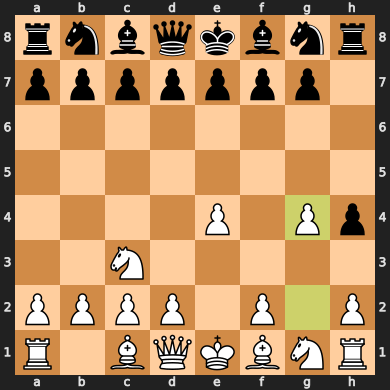

In [10]:
def test_game(p1, p2):
    # board = chess.Board("K7/8/8/8/8/6Q1/5p2/k3p3 b KQkq - 0 4")
    board = chess.Board()
    current_player = p1

    while not board.is_checkmate():
        score_dict, move = current_player(board, board.turn, MAX_DEPTH)
        difference_dict, significant_scores = explain_move(board, board.turn, move)
        # board.push(move)
        
        clear_output(True)
        print("=== Commentary of the below board ===")
        print(f"move chosen = {move}")
        print(f"move's own score_dict = {score_dict}")
        print(f"post minus pre move score dict = {difference_dict}")
        print(f"significant_scores = {significant_scores}")
        display(board)
        
        current_player = p1 if board.turn == chess.WHITE else p2
        if input() == "q":
            break

test_game(minimax, get_random_move)

Notes:
- (bug) mobility scores seem weird, returning 0 or a more negative number the more moves the piece can make 

In [45]:
def grade_game(p1, p2):
    p1_wins = 0
    # p2_wins = 0

    for i in range(10):
        board = chess.Board()
        current_player = p1
        while not board.is_checkmate() and not board.is_stalemate():
            _, move = current_player(board, MAX_DEPTH, board.turn)
            board.push(move)
            current_player = p1 if board.turn == chess.WHITE else p2
        
        result = board.outcome().result()
        print(str(i) + ": " + result)
        if result == "1-0":
            p1_wins += 1
        # elif result == "0-1":
        #     p2_wins += 1
    return "p1 won {p1_wins} games out of 10" 

print(grade_game(minimax, get_random_move))

0: 1-0
1: 1/2-1/2
2: 1-0
3: 1/2-1/2
4: 1-0
5: 1-0
6: 1-0
7: 1-0
8: 1-0
9: 1-0
8


In [10]:
def get_expectimax_move(board:chess.Board, player):
    opponent = not player

    def max_value(b:chess.Board, depth:int):
        e = evaluation(b)
        if depth == MAX_DEPTH or abs(e) == inf:
            return e, None
        
        v = -inf
        move = None
        for m in b.legal_moves:
            temp = b.copy()
            temp.push(m)
            s_val = chance_value(temp, depth + 1)
            if s_val > v:
                v, move = s_val, m
        return v, move

    def chance_value(b:chess.Board, depth:int):
        e = evaluation(b)
        if depth == MAX_DEPTH or abs(e) == inf:
            return e, None
        
        successors = []
        for m in b.legal_moves:
            temp = b.copy()
            temp.push(m)
            successors.append(max_value(temp, depth + 1)[0])
        return sum(successors) / len(successors)
    
    return max_value(board, 0)[1]